# Installation

In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 2.6 MB/s 
     |████████████████████████████████| 3.5 MB 2.6 MB/s 
     |████████████████████████████████| 407 kB 5.4 MB/s 
     |████████████████████████████████| 41 kB 374 kB/s 


# Imports

In [2]:
import os.path as osp
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import ARGVA
from torch_geometric.utils import train_test_split_edges

# Data Part

In [3]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset.get(0)

Processing...
Done!


In [4]:
num_nodes = data.x.shape[0]

In [5]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)
data

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], y=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])

# Model Part

In [6]:
class VEncoder(torch.nn.Module):
  def __init__(self, in_channels, out_channels):
    super(VEncoder, self).__init__()
    self.conv1=GCNConv(in_channels, 2 * out_channels, cached=True)
    self.conv_mu=GCNConv(2 * out_channels, out_channels, cached=True)
    self.conv_logstd=GCNConv(2*out_channels, out_channels, cached = True)

  def forward(self, x, edge_index):
    x=F.relu(self.conv1(x, edge_index))

    return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [7]:
class Discriminator(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(Discriminator, self).__init__()
    self.lin1=torch.nn.Linear(in_channels, hidden_channels)
    self.lin2=torch.nn.Linear(hidden_channels, hidden_channels)
    self.lin3=torch.nn.Linear(hidden_channels, out_channels)

  def forward(self, x):

    x=F.relu(self.lin1(x))
    x=F.relu(self.lin2(x))
    x=self.lin3(x)

    return x

In [8]:
latent_size = 32
encoder = VEncoder(data.num_features, out_channels=latent_size)

discriminator = Discriminator(in_channels=latent_size, hidden_channels=64, 
                              out_channels=1)

In [9]:
model = ARGVA(encoder, discriminator)

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
model, data = model.to(device), data.to(device)

> optimizers

In [10]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)

In [14]:
ARGVA??

In [15]:
model.VGAE??

> So we can see that there are a no of useful attributes which are already implemented for us in PyG

In [16]:
model.discriminator_loss??

In [21]:
def train(model, discriminator):
  model.train()
  encoder_optimizer.zero_grad()

  z= model.encode(data.x, data.train_pos_edge_index)

  for i in range(5):
    idx=range(num_nodes)
    discriminator.train()
    discriminator_optimizer.zero_grad()
    discriminator_loss=model.discriminator_loss(z[idx])
    discriminator_loss.backward(retain_graph=True)
    discriminator_optimizer.step()

  loss=0
  loss = loss + model.reg_loss(z)
  loss = loss + model.recon_loss(z, data.train_pos_edge_index)
  loss = loss + (1 / data.num_nodes) * model.kl_loss()
  loss.backward()

  encoder_optimizer.step()
  
  return loss
  

In [18]:
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    # Cluster embedded values using k-means.
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters=7, random_state=0).fit(kmeans_input)
    pred = kmeans.predict(kmeans_input)

    labels = data.y.cpu().numpy()
    completeness = completeness_score(labels, pred)
    hm = homogeneity_score(labels, pred)
    nmi = v_measure_score(labels, pred)

    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

    return auc, ap, completeness, hm, nmi

In [22]:
for epoch in range(1, 101):
    loss = train(model, discriminator)
    auc, ap, completeness, hm, nmi = test()
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
           f'AP: {ap:.3f}, Completeness: {completeness:.3f}, '
           f'Homogeneity: {hm:.3f}, NMI: {nmi:.3f}'))

Epoch: 001, Loss: 5.650, AUC: 0.724, AP: 0.735, Completeness: 0.095, Homogeneity: 0.096, NMI: 0.096
Epoch: 002, Loss: 5.006, AUC: 0.695, AP: 0.715, Completeness: 0.095, Homogeneity: 0.094, NMI: 0.094
Epoch: 003, Loss: 4.402, AUC: 0.684, AP: 0.707, Completeness: 0.060, Homogeneity: 0.058, NMI: 0.059
Epoch: 004, Loss: 3.949, AUC: 0.685, AP: 0.706, Completeness: 0.109, Homogeneity: 0.106, NMI: 0.107
Epoch: 005, Loss: 3.588, AUC: 0.693, AP: 0.712, Completeness: 0.116, Homogeneity: 0.112, NMI: 0.114
Epoch: 006, Loss: 3.200, AUC: 0.704, AP: 0.724, Completeness: 0.131, Homogeneity: 0.126, NMI: 0.128
Epoch: 007, Loss: 2.920, AUC: 0.708, AP: 0.732, Completeness: 0.167, Homogeneity: 0.160, NMI: 0.163
Epoch: 008, Loss: 2.613, AUC: 0.712, AP: 0.738, Completeness: 0.209, Homogeneity: 0.208, NMI: 0.209
Epoch: 009, Loss: 2.409, AUC: 0.722, AP: 0.744, Completeness: 0.236, Homogeneity: 0.235, NMI: 0.235
Epoch: 010, Loss: 2.222, AUC: 0.732, AP: 0.754, Completeness: 0.242, Homogeneity: 0.246, NMI: 0.244


In [23]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


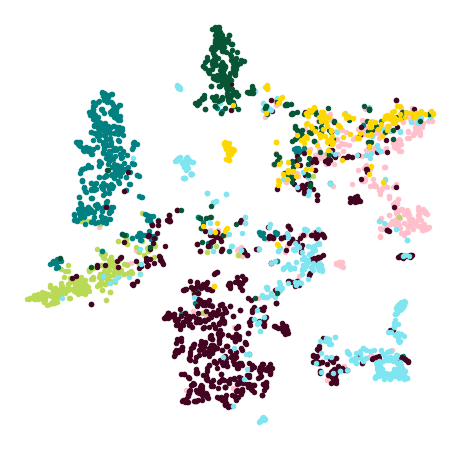

In [24]:
#%%
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)